# Testing the X_feature_select.npy using Random Forest 

The objective here is to evaluate and tune a Random Forest classifier on the reduced feature set for a classification problem using cross-validation and a robust model evaluation process. The classifier is based on decision trees, though it improves on them by combining the predictions of many trees rather than relying on just one. The reason why this classifier is useful is because the multiple trees also known as the ensemble, reduced overfitting compared to a single decision tree. The randomness  increases generalization by making trees diverse, good accuracy, works well with non-linear relationship data environments, can easily adjust class weights which supports class imbalance and can rank which features matter most in predictions.

In [48]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint


In [49]:
# let us load the datasets
X = np.load('X_feature_select.npy')
y = np.load('y_enc.npy')

# Splitting the 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In the above cell, train_test_split reserves 20% of the data for testing model generalization, stratify = y ensures that the class distribution is preserved in both sets because this is key for classification, whereas random_state=42, makes the results reproducible. In the next cell, we are going to define our hyperparameters (the different settings defined before training a machine learning model) and the search space ( all the possible range of values we allow each hyperparameter to explore during tuning. 

In [50]:
# defining hyperparameter search space
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]
}

Random forests have several key hyperparameters that control model complexity and performance. the n_estimators: the number of trees in the forest. The more the trees the more stability but higher computation cost. max_depth prevents trees from growing too deep thus controlling overfitting. min_samples_split and min_samples_leaf control tree branching and help generalize better, while the max_features hyperparameter controls the number of features to consider when looking for the best split. 

In [51]:
# initializing the Random Forest Model with a fixed random seed for reproducibility
rf = RandomForestClassifier(random_state=42)

# Defining cross-validation strategy. StratifiedKFold ensures that each fold has a balanced class distribution
# 5 fold is a good balance btn bias/variance and training time
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [52]:
# lets run hyperparameter tuning
search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=50, cv=cv_strategy, verbose=1,
    n_jobs=-1, scoring='f1_weighted', random_state=42
)
search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff67846f010>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff678354b50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff67844e7d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff678338f90>},
                   random_state=42, scoring='f1_weighted', verbose=1)

In the cell above, we use the RandomizedSearchCV which is a tool that helps us to automatically find the best hyperparameters for the model instead of manually trying out different parameter combinations. In this case, it tries out 50 different sets of hyperparameters and these are randomly selected from my defined hyperparameter search space. 5 folds cross-validation is used and for each set of hyperparameters, the training data is split into 5 parts (folds), and the model is trained and validated 5 times, each time using a different fold as the validation set and the rest for training. Therefore the total number of model trainings that will happen will be 50 candidates * 5 folds = 250 times during the hyperparameter search. this process helps to find the best combination of hyperparameters that generalises well across different data splits.

Therefore, We used RandomizedSearchCV over other hyperparameter tuning methods like GridSearchCV because it offers a more efficient and scalable approach, especially when working with large or continuous search spaces. Instead of exhaustively testing every possible combination, as GridSearchCV does, RandomizedSearchCV samples a fixed number of hyperparameter combinations from specified distributions, significantly reducing computation time while still exploring a diverse set of potential configurations. This makes it ideal for complex models like Random Forests, where many hyperparameters can interact in non-obvious ways. Additionally, by incorporating cross-validation, it ensures that each configuration is robustly evaluated, helping to avoid overfitting and leading to better generalisation on unseen data.

In [53]:
# Evaluating the best model
best_rf = search.best_estimator_

y_pred = best_rf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Best Hyperparameters:\n", search.best_params_)


Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.60      0.75      0.67         4
           2       1.00      0.75      0.86         4
           3       1.00      0.50      0.67         4
           4       0.80      1.00      0.89         4

    accuracy                           0.80        20
   macro avg       0.84      0.80      0.79        20
weighted avg       0.84      0.80      0.79        20

Confusion Matrix:
 [[4 0 0 0 0]
 [1 3 0 0 0]
 [0 1 3 0 0]
 [0 1 0 2 1]
 [0 0 0 0 4]]
Best Hyperparameters:
 {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 13, 'n_estimators': 513}


According to the report above, the Random Forest classifier achieved an overall accuracy of 80% on the test set, demonstrating solid performance across the five cardiac classes. The macro and weighted F1-scores were both 0.79, indicating a balanced model that performs reasonably well across all classes despite the small dataset. Class 0 (DCM) and class 4 (RV) were predicted with perfect recall (1.00), meaning the model identified all true cases correctly, and they also had high F1-scores (0.89), reflecting good precision. In contrast, class 3 (NOR) had the lowest recall (0.50), suggesting the model struggled to identify all normal cases, likely misclassifying them as similar conditions (as shown in the confusion matrix). Class 2 (MINF) achieved perfect precision (1.00) but missed one case, slightly reducing recall. The confusion matrix reveals most misclassifications were within close clinical neighbours, such as class 3 being confused with class 1. Overall, the selected hyperparameters, a relatively shallow depth (max_depth=7) and log2 feature sampling, helped prevent overfitting while maintaining strong predictive power. This model shows promise, but further validation with a larger dataset would be ideal.

# Visualising feature importance

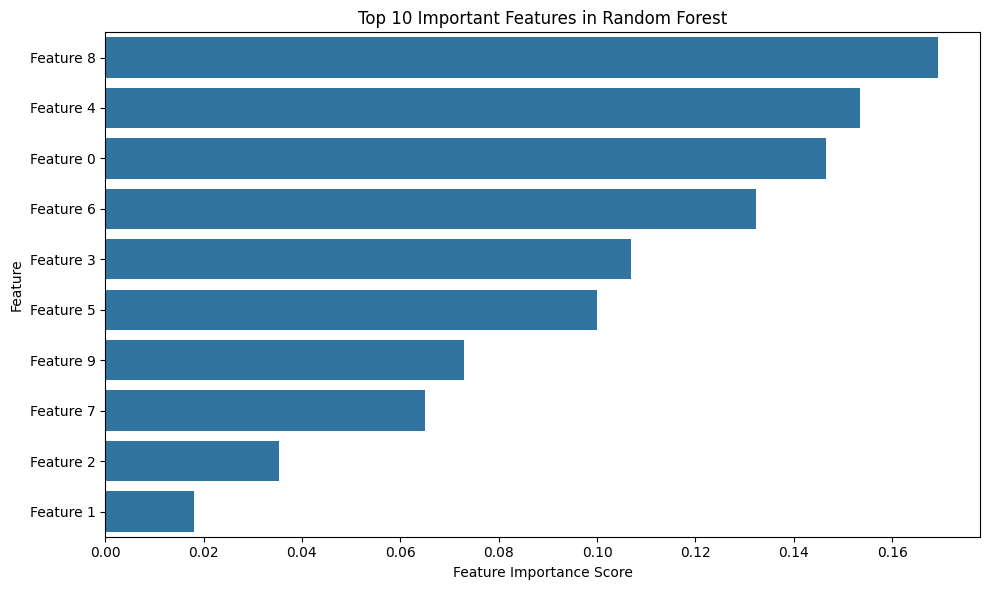

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the best model
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order
top_n = 10  # Number of top features to display

# plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices[:top_n]], y=[f"Feature {i}" for i in indices[:top_n]])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features in Random Forest")
plt.tight_layout()
plt.savefig("feature_importances.png")
plt.show()


If we could recover the original features following the exact feature selection method that was used to create the X_feature_select.npy @AZUCENA, we could get the real names of the most important features in  random forest.  

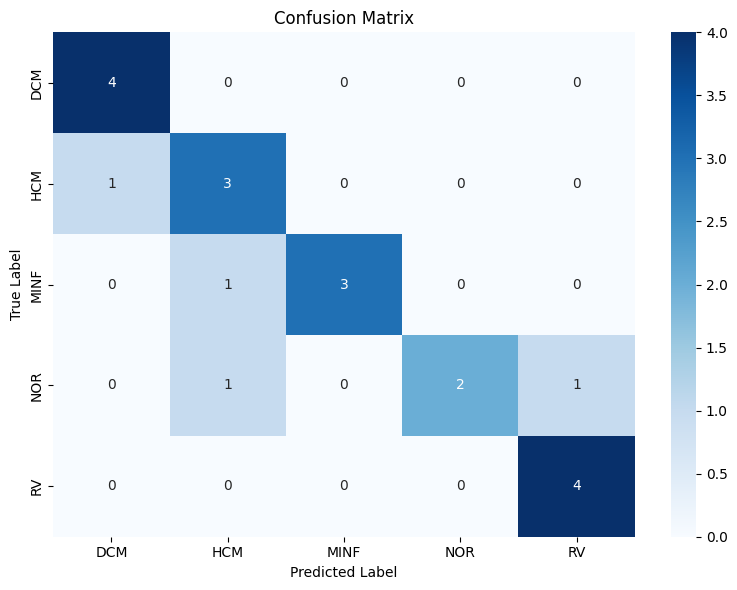

In [55]:
# Use your class labels
class_names = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


In [56]:
import pandas as pd

# let us generate and save the classification report as CSV
report_dict = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv("random_forest_classification_report.csv")
print("Classification report saved to random_forest_classification_report.csv")

# let us save the best parameters
pd.DataFrame([search.best_params_]).to_csv("best_rf_hyperparameters.csv", index=False)
print("Best hyperparameters saved to best_rf_hyperparameters.csv")



Classification report saved to random_forest_classification_report.csv
Best hyperparameters saved to best_rf_hyperparameters.csv
